In [1]:

import os

def count_images(directory):
    count = 0
    for filename in os.listdir(directory):
        count+=1
    return count

train_ant_count = count_images('dataset/train/ant')
train_shark_count = count_images('dataset/train/shark')
test_ant_count = count_images('dataset/test/ant')
test_shark_count = count_images('dataset/test/shark')

print(f'Training ant: {train_ant_count}, Training shark: {train_shark_count}')
print(f'Testing ant: {test_ant_count}, Testing shark: {test_shark_count}')

Training ant: 80, Training shark: 80
Testing ant: 20, Testing shark: 20


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # For model summary
import time
import torch.nn as nn

In [13]:
# Define the transformations (resize and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency
    transforms.ToTensor(),           # Convert to tensor for processing
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.215])

])

# Set the paths for the training and testing directories
output_dir_base = './dataset'
train_dir = os.path.join(output_dir_base, 'train')
test_dir = os.path.join(output_dir_base, 'test')

# Ensure the directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Training or testing directory not found.")

# Load the training dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the training DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Create the testing DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the size of training and testing datasets
print(f'Total training samples: {len(train_dataset)}')
print(f'Total testing samples: {len(test_dataset)}')

# Print class labels (to confirm that subdirectories are used as class labels)
print(f'Class labels: {train_dataset.classes}')

# Example: Print the number of batches in each DataLoader
print(f'Number of training batches: {len(train_loader)}')
print(f'Number of testing batches: {len(test_loader)}')

# Verify class-to-index mapping
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

Total training samples: 160
Total testing samples: 40
Class labels: ['ant', 'shark']
Number of training batches: 5
Number of testing batches: 3
{'ant': 0, 'shark': 1}
{'ant': 0, 'shark': 1}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
import shutil
import os

def clear_runs_directory(model_name):
    runs_dir = "runs"
    # Define subdirectories to clear
    subdirs = [f"{model_name}_Images", f"{model_name}_Test", f"{model_name}_Train"]
    
    for subdir in subdirs:
        model_runs_dir = os.path.join(runs_dir, subdir)
        
        if os.path.exists(model_runs_dir):
            shutil.rmtree(model_runs_dir)  # Deletes the specific subdirectory
            print(f"Cleared subdirectory: {model_runs_dir}")
        else:
            print(f"No subdirectory found: {model_runs_dir}")


# Update the train_and_evaluate function to use separate directories for each model
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, batch_size=16, learning_rate=1e-4, model_name='VGG'):
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Clear existing logs for the specific model
    clear_runs_directory(model_name)

    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create unique SummaryWriter instances per model
    writer_train = SummaryWriter(f"runs/{model_name}/train")
    writer_test = SummaryWriter(f"runs/{model_name}/test")

    # Log model graph
    images, _ = next(iter(train_loader))
    writer_train.add_graph(model, images.to(device))

    # Initialize tracking variables
    step_train, step_test = 0, 0
    total_training_time = 0
    total_test_time = 0
    epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies = [], [], []

    # Training and evaluation loop
    for epoch in range(num_epochs):
        model.train()
        iter_train_losses, iter_train_accuracies = [], []

        start_total_time = time.time()
        for batch_idx, (data, targets) in enumerate(train_loader):
            
            # Move data to the device
            data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            iter_train_losses.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training accuracy
            predictions = (scores > 0.5).float()
            correct = (predictions == targets).sum().item()
            train_accuracy = correct / data.shape[0]
            iter_train_accuracies.append(train_accuracy)

            # Log to TensorBoard for training
            writer_train.add_scalar("Loss/train", loss.item(), global_step=step_train)
            writer_train.add_scalar("Accuracy/train", train_accuracy, global_step=step_train)
            step_train += 1

            start_test_time  = time.time()

            # Test phase
            model.eval()
            iter_test_accuracies = []
            with torch.no_grad():
                for data, targets in test_loader:
                    data, targets = data.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32).unsqueeze(1)

                    # Forward pass
                    scores = model(data)

                    # Test accuracy
                    predictions = (scores > 0.5).float()
                    correct = (predictions == targets).sum().item()
                    test_accuracy = correct / data.shape[0]
                    iter_test_accuracies.append(test_accuracy)

                    # Log to TensorBoard for testing
                    writer_test.add_scalar("Accuracy/test", test_accuracy, global_step=step_test)
                    step_test += 1

            end_test_time = time.time()
            total_test_time += end_test_time - start_test_time

        end_total_time = time.time()
        total_training_time += end_total_time - start_total_time

        # Calculate and print the epoch metrics
        avg_train_loss = sum(iter_train_losses) / len(iter_train_losses)
        avg_train_acc = sum(iter_train_accuracies) / len(iter_train_accuracies)
        avg_test_acc = sum(iter_test_accuracies) / len(iter_test_accuracies)
        
        print(f"\nEpoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {avg_train_acc:.4f}, "
              f"Test Accuracy: {avg_test_acc:.4f}")

        epoch_train_losses.append(avg_train_loss)
        epoch_train_accuracies.append(avg_train_acc)
        epoch_test_accuracies.append(avg_test_acc)

    print(f"\n------------\nTotal Training Time: {total_training_time:.2f} seconds\n-------------\n")

    # Close the writers
    writer_train.close()
    writer_test.close()

    return epoch_train_losses, epoch_train_accuracies, epoch_test_accuracies


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot training loss and accuracy
def plot_metrics(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Testing Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_test_predictions_grid(model, test_loader, num_images=40, grid_size=(5, 8), device='cpu', writer=None):
    model.eval()
    images, true_labels, predicted_labels, incorrect_indices = [], [], [], []

    # Mean and standard deviation values used for normalization
    mean = np.array([0.485, 0.456, 0.406])  # Example: ImageNet mean
    std = np.array([0.229, 0.224, 0.215])   # Example: ImageNet std

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            if len(images) >= num_images:
                break
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()

            # Store images and labels for visualization
            images.extend(inputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds)

            # Find and store incorrect indices
            for i, (true_label, pred) in enumerate(zip(labels.cpu().numpy(), preds)):
                if true_label != int(pred):
                    incorrect_indices.append(batch_idx * test_loader.batch_size + i)

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels).squeeze().astype(int)
    correct = (true_labels == predicted_labels).sum()
    total = true_labels.shape[0]
    accuracy = correct / total
    print(f"Accuracy on {total} test images: {accuracy:.4f}")

    # Print the indices of incorrectly labeled images
    print("Indices of incorrectly labeled images:", incorrect_indices)

    # Create a figure for the image grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 10))
    fig.suptitle("True and Predicted Labels on Test Images", fontsize=16)

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            img = images[idx].transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

            # Denormalize the image
            img = img * std + mean  # Reverse the normalization
            img = np.clip(img, 0, 1)  # Ensure pixel values are in the [0, 1] range

            ax.imshow(img)
            ax.axis("off")
            true_label = int(true_labels[idx])
            predicted_label = int(predicted_labels[idx].squeeze())
            ax.set_title(f"True: {true_label} | Pred: {predicted_label}",
                         color="green" if true_label == predicted_label else "red")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Log the grid of images to TensorBoard
    writer.add_figure("Test Predictions Grid", fig)

    # Return the true and predicted labels for further evaluation
    return true_labels, predicted_labels, incorrect_indices



# Plot confusion matrix (only local display)
def plot_confusion_matrix(true_labels, predicted_labels, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

### VGG (1 block)

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG1Block(nn.Module):
    def __init__(self, num_classes=1):  # Corrected from _init_ to __init__
        super(VGG1Block, self).__init__()
        
        # A single convolutional layer followed by max pooling
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with a 2x2 kernel
        )
        
        # Fully connected layers
        # After Conv2d + MaxPool2d, the size will be reduced by a factor of 2 (224 -> 112)
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 112 * 112, 128),  # Adjust size for 112x112 after max pooling
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG1Block()

# Print the summary of the model
summary(model, (3, 224, 224))  # Input size of 224x224x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
           Flatten-4               [-1, 401408]               0
            Linear-5                  [-1, 128]      51,380,352
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 30.63
Params size (MB): 196.00
Estimated Total Size (MB): 227.21
----------------------------------------------------------------


No subdirectory found: runs\VGG1Block_Images
No subdirectory found: runs\VGG1Block_Test
No subdirectory found: runs\VGG1Block_Train

Epoch [1/10] - Train Loss: 0.3037, Train Accuracy: 0.8375, Test Accuracy: 1.0000

Epoch [2/10] - Train Loss: 0.0683, Train Accuracy: 0.9750, Test Accuracy: 0.9792

Epoch [3/10] - Train Loss: 0.0466, Train Accuracy: 0.9875, Test Accuracy: 0.9375

Epoch [4/10] - Train Loss: 0.0298, Train Accuracy: 0.9875, Test Accuracy: 1.0000

Epoch [5/10] - Train Loss: 0.0223, Train Accuracy: 0.9938, Test Accuracy: 1.0000

Epoch [6/10] - Train Loss: 0.0126, Train Accuracy: 0.9938, Test Accuracy: 1.0000

Epoch [7/10] - Train Loss: 0.0058, Train Accuracy: 1.0000, Test Accuracy: 0.9792

Epoch [8/10] - Train Loss: 0.0046, Train Accuracy: 1.0000, Test Accuracy: 0.9792

Epoch [9/10] - Train Loss: 0.0039, Train Accuracy: 1.0000, Test Accuracy: 0.9792

Epoch [10/10] - Train Loss: 0.0032, Train Accuracy: 1.0000, Test Accuracy: 0.9792

------------
Total Training Time: 315.53 secon

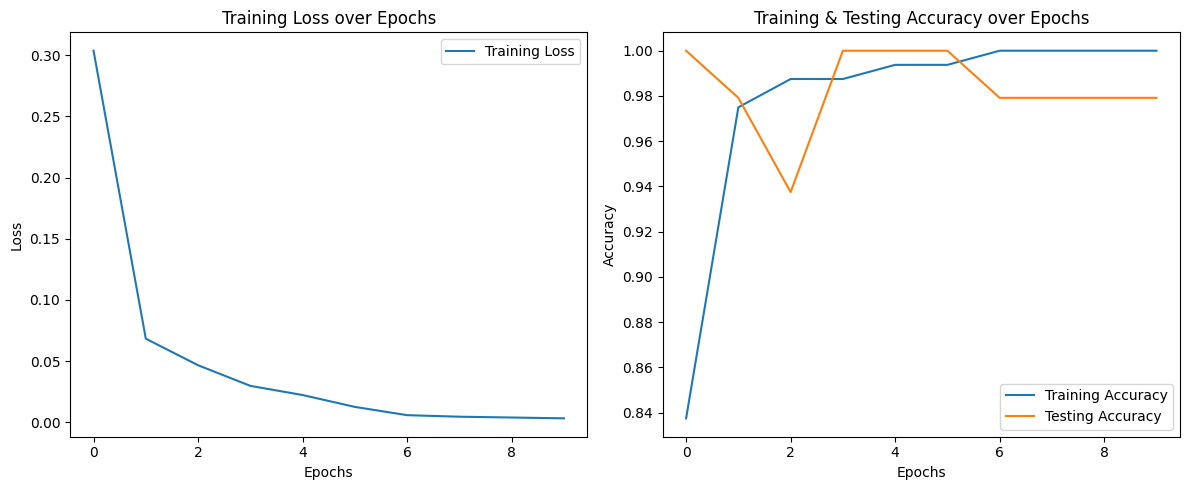

C:\Users\persu\AppData\Local\Temp\ipykernel_18592\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 0.9750
Indices of incorrectly labeled images: [28]


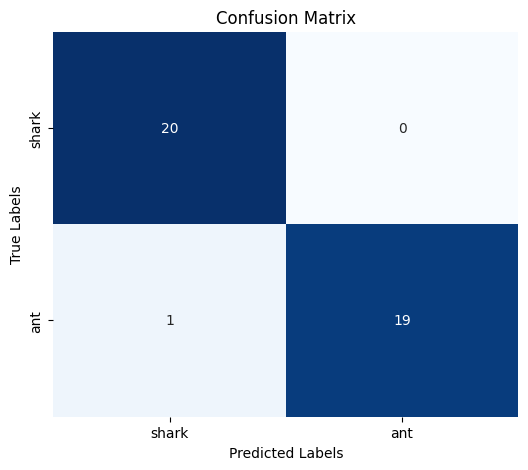

In [7]:
model = VGG1Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = "VGG1Block"
)

writer_images = SummaryWriter("runs/VGG1Block_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### VGG (2 block)

In [8]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG2Block(nn.Module):
    def __init__(self, num_classes=1):  # Adjust the number of classes as needed
        super(VGG2Block, self).__init__()
        
        # Block with two convolutional layers and max pooling after each
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling after first Conv layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 64 filters for second layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling after second Conv layer
        )
        
        # Fully connected layers
        # After two MaxPool layers, the size is reduced by a factor of 4 (224 -> 56), with 64 channels
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),  # Updated size for 56x56 with 64 channels
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG2Block()

# Print the summary of the model
summary(model, (3, 224, 224))  # Input size of 224x224x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
           Flatten-7               [-1, 200704]               0
            Linear-8                  [-1, 128]      25,690,240
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 1]             129
          Sigmoid-11                    [-1, 1]               0
Total params: 25,709,761
Trainable params: 25,709,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

Cleared subdirectory: runs\VGG2Block_Images
No subdirectory found: runs\VGG2Block_Test
No subdirectory found: runs\VGG2Block_Train

Epoch [1/10] - Train Loss: 0.5295, Train Accuracy: 0.8187, Test Accuracy: 0.9792

Epoch [2/10] - Train Loss: 0.2526, Train Accuracy: 0.9812, Test Accuracy: 0.9792

Epoch [3/10] - Train Loss: 0.1545, Train Accuracy: 0.9812, Test Accuracy: 0.9792

Epoch [4/10] - Train Loss: 0.1066, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [5/10] - Train Loss: 0.0826, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [6/10] - Train Loss: 0.0687, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [7/10] - Train Loss: 0.0594, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [8/10] - Train Loss: 0.0523, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [9/10] - Train Loss: 0.0472, Train Accuracy: 0.9875, Test Accuracy: 0.9792

Epoch [10/10] - Train Loss: 0.0426, Train Accuracy: 0.9875, Test Accuracy: 0.9792

------------
Total Training Time: 356.91 second

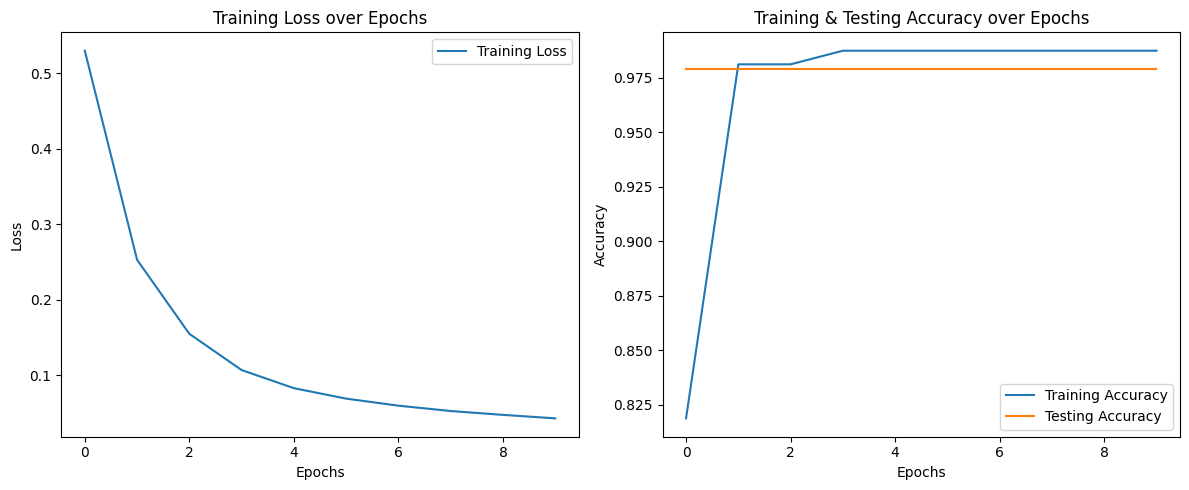

C:\Users\persu\AppData\Local\Temp\ipykernel_18592\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 0.9750
Indices of incorrectly labeled images: [28]


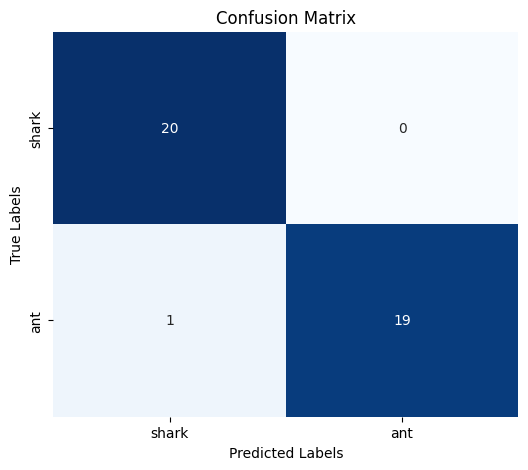

In [9]:
model = VGG2Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = "VGG2Block"
)

writer_images = SummaryWriter("runs/VGG2Block_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### VGG (3 block) with augmentation.

In [10]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG3Block(nn.Module):
    def __init__(self, num_classes=1):
        super(VGG3Block, self).__init__()
        
        # Block with three convolutional layers followed by max pooling
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Another 64 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling with a 2x2 kernel
        )
        
        # Fully connected layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),  # Adjust size for 112x112 after max pooling
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG3Block()

# Print the summary of the model
summary(model, (3, 224, 224))  # Input size of 224x224x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
          Flatten-10               [-1, 100352]               0
           Linear-11                  [-1, 128]      12,845,184
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
          Sigmoid-14                   

In [14]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# Define data augmentation transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),   # Rotate images by up to 30 degrees
    transforms.RandomResizedCrop(224),  # Randomly crop and resize images to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random brightness/contrast adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# # Apply basic transforms for test data (no augmentation)
# test_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Load training and testing datasets
train_dataset = datasets.ImageFolder('dataset/train', transform=train_transforms)
# test_dataset = datasets.ImageFolder('dataset/test', transform=test_transforms)

# Load data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)




No subdirectory found: runs\VGG3Block_Images
No subdirectory found: runs\VGG3Block_Test
No subdirectory found: runs\VGG3Block_Train

Epoch [1/10] - Train Loss: 0.6732, Train Accuracy: 0.6250, Test Accuracy: 0.9167

Epoch [2/10] - Train Loss: 0.5915, Train Accuracy: 0.7875, Test Accuracy: 0.9167

Epoch [3/10] - Train Loss: 0.5164, Train Accuracy: 0.8875, Test Accuracy: 0.9375

Epoch [4/10] - Train Loss: 0.4510, Train Accuracy: 0.9250, Test Accuracy: 0.9792

Epoch [5/10] - Train Loss: 0.4021, Train Accuracy: 0.8875, Test Accuracy: 0.9375

Epoch [6/10] - Train Loss: 0.3336, Train Accuracy: 0.9125, Test Accuracy: 0.9583

Epoch [7/10] - Train Loss: 0.3161, Train Accuracy: 0.9250, Test Accuracy: 0.9792

Epoch [8/10] - Train Loss: 0.2472, Train Accuracy: 0.9375, Test Accuracy: 0.9792

Epoch [9/10] - Train Loss: 0.2397, Train Accuracy: 0.9187, Test Accuracy: 0.9792

Epoch [10/10] - Train Loss: 0.2238, Train Accuracy: 0.9375, Test Accuracy: 0.9792

------------
Total Training Time: 604.69 secon

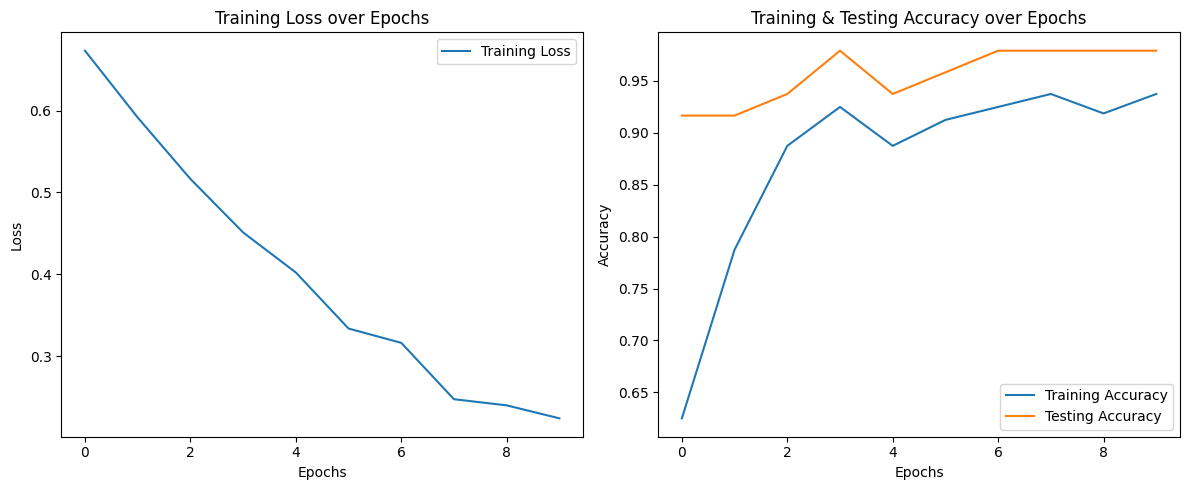

C:\Users\persu\AppData\Local\Temp\ipykernel_18592\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 0.9750
Indices of incorrectly labeled images: [28]


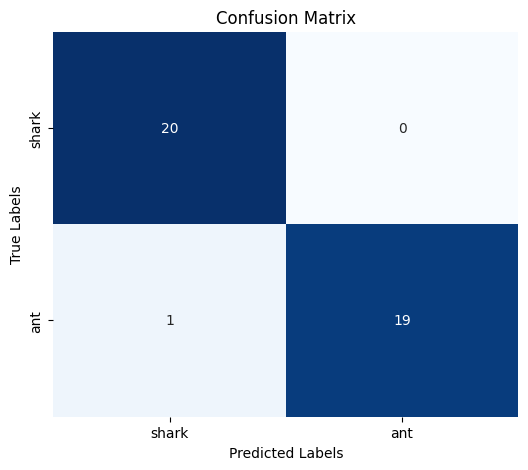

In [15]:
model = VGG3Block()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 10, batch_size=16, learning_rate=1e-5,model_name = "VGG3Block"
)

writer_images = SummaryWriter("runs/VGG3Block_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### Transfer learning using VGG16 or VGG19 with tuning all layers

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes=2):  # Adjust `num_classes` for your dataset
        super(VGG16TransferLearning, self).__init__()

        # Load the pretrained VGG-16 model
        self.vgg = models.vgg16(pretrained=True)

        # Enable fine-tuning on all layers
        for param in self.vgg.parameters():
            param.requires_grad = True

        # Replace the classifier's final layer to match the number of classes in your dataset
        self.vgg.classifier[6] = nn.Linear(4096, num_classes)
        self.sigmoid = nn.Sigmoid()  # Add a sigmoid layer for binary classification

    def forward(self, x):
        x = self.vgg(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
model = VGG16TransferLearning(num_classes=1)  # Set `num_classes=1` for binary classification

# Print the model summary
summary(model, (3, 224, 224))  # Input size of 224x224x3

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)


c:\Users\persu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\persu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Cleared subdirectory: runs\VGG16_Images
No subdirectory found: runs\VGG16_Test
No subdirectory found: runs\VGG16_Train

Epoch [1/5] - Train Loss: 0.6538, Train Accuracy: 0.6250, Test Accuracy: 0.9750

Epoch [2/5] - Train Loss: 0.3000, Train Accuracy: 0.9437, Test Accuracy: 1.0000

Epoch [3/5] - Train Loss: 0.0877, Train Accuracy: 1.0000, Test Accuracy: 1.0000

Epoch [4/5] - Train Loss: 0.0257, Train Accuracy: 0.9938, Test Accuracy: 1.0000

Epoch [5/5] - Train Loss: 0.0216, Train Accuracy: 0.9938, Test Accuracy: 1.0000

------------
Total Training Time: 1353.69 seconds
-------------



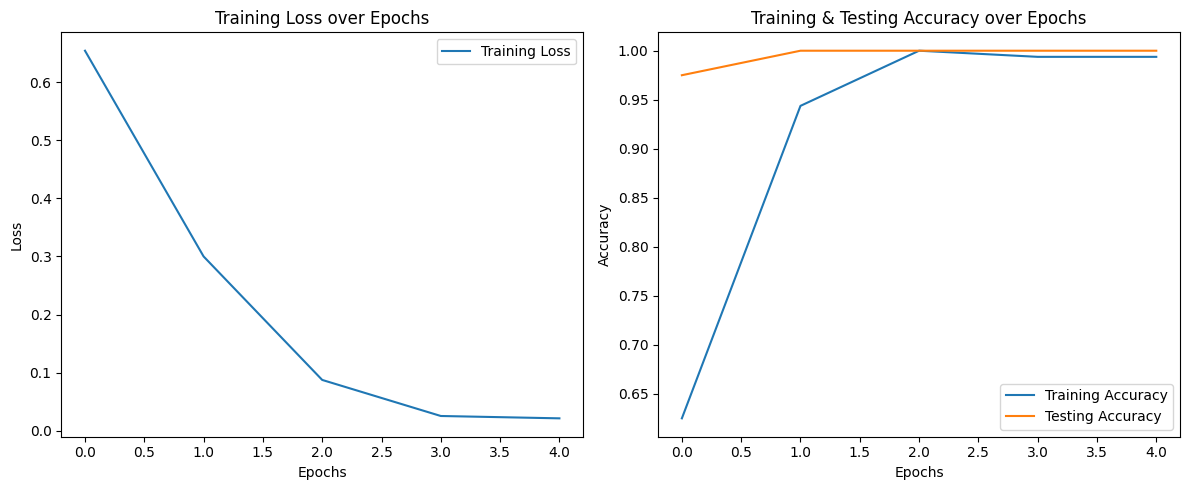

C:\Users\persu\AppData\Local\Temp\ipykernel_16892\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 1.0000
Indices of incorrectly labeled images: []


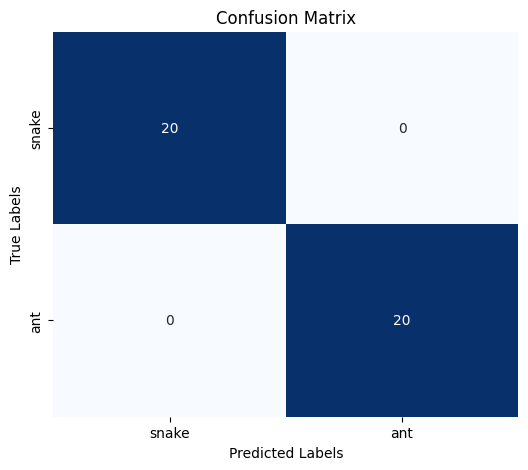

In [14]:
model = VGG16TransferLearning(num_classes=1)

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 5, batch_size=16, learning_rate=1e-5,model_name = "VGG16"
)

writer_images = SummaryWriter("runs/VGG16_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### Transfer learning using VGG16 or VGG19 with tuning only final MLP layers (excluding convolution layers)


In [15]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16TransferMLP(nn.Module):
    def __init__(self, num_classes=1):  # Default for binary classification
        super(VGG16TransferMLP, self).__init__()

        # Load pre-trained VGG-16 model
        self.vgg = models.vgg16(pretrained=True)

        # Freeze all VGG layers except the classifier layers (MLP)
        for param in self.vgg.features.parameters():
            param.requires_grad = False

        # Replace the classifier with new layers
        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # First fully connected layer from VGG-16
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),   # Second fully connected layer from VGG-16
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.vgg(x)
        return x

# Create the model
model = VGG16TransferMLP()

# Print the summary of the model (optional)
from torchsummary import summary
summary(model, (3, 224, 224))  # Assuming input size of 224x224x3


c:\Users\persu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\persu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

No subdirectory found: runs\VGG16MLP_Images
No subdirectory found: runs\VGG16MLP_Test
No subdirectory found: runs\VGG16MLP_Train

Epoch [1/5] - Train Loss: 0.5682, Train Accuracy: 0.8500, Test Accuracy: 1.0000

Epoch [2/5] - Train Loss: 0.3001, Train Accuracy: 0.9875, Test Accuracy: 1.0000

Epoch [3/5] - Train Loss: 0.1450, Train Accuracy: 1.0000, Test Accuracy: 1.0000

Epoch [4/5] - Train Loss: 0.0846, Train Accuracy: 0.9938, Test Accuracy: 1.0000

Epoch [5/5] - Train Loss: 0.0519, Train Accuracy: 1.0000, Test Accuracy: 1.0000

------------
Total Training Time: 938.90 seconds
-------------



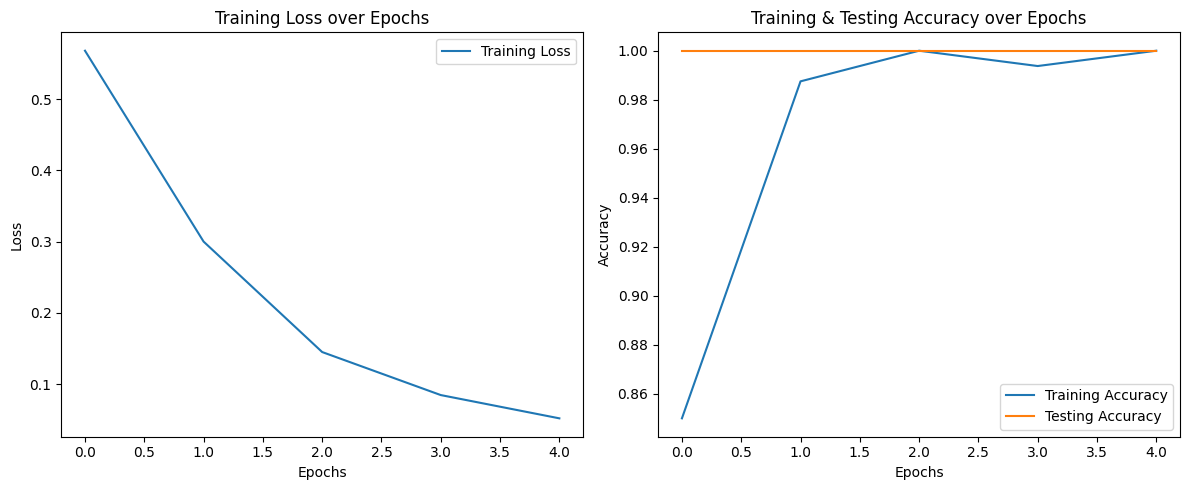

C:\Users\persu\AppData\Local\Temp\ipykernel_16892\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 1.0000
Indices of incorrectly labeled images: []


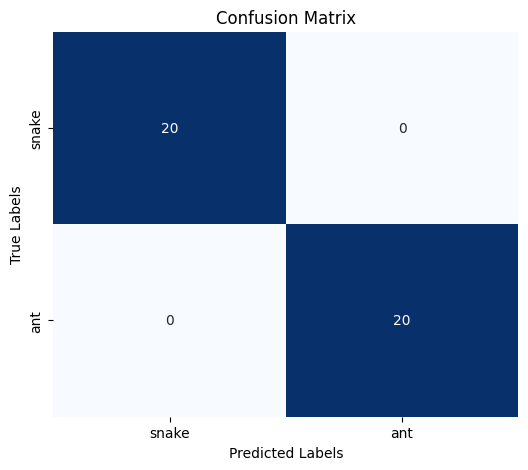

In [16]:
model = VGG16TransferMLP()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 5, batch_size=16, learning_rate=1e-5,model_name = "VGG16MLP"
)

writer_images = SummaryWriter("runs/VGG16MPL_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### Evaluating a model with number of pararmeters equal to the number of parameters in VGG16 model.

In [17]:
import torch
import torch.nn as nn
from torchsummary import summary

class VGG5Blocks(nn.Module):
    def __init__(self, num_classes=1):  
        super(VGG5Blocks, self).__init__()
        
        # Define 5 blocks with convolutional layers and max pooling
        self.conv_block = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x112x112
            
            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x56x56
            
            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256x28x28
            
            # Convolutional Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 512x14x14
            
            # Convolutional Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 512x7x7
        )
        
        # Fully connected layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),  # First FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),  # Second FC layer
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Final layer: 1 output for binary classification
            nn.Sigmoid()  # Use sigmoid for binary classification
        
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

# Create the model
model = VGG5Blocks()

# Print the summary of the model
summary(model, (3, 224, 224))  # Input size of 224x224x3


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Cleared subdirectory: runs\VGG5Blocks_Images
No subdirectory found: runs\VGG5Blocks_Test
No subdirectory found: runs\VGG5Blocks_Train

Epoch [1/5] - Train Loss: 0.6936, Train Accuracy: 0.5000, Test Accuracy: 0.5833

Epoch [2/5] - Train Loss: 0.6933, Train Accuracy: 0.5000, Test Accuracy: 0.5833

Epoch [3/5] - Train Loss: 0.6934, Train Accuracy: 0.5000, Test Accuracy: 0.5833

Epoch [4/5] - Train Loss: 0.6933, Train Accuracy: 0.5000, Test Accuracy: 0.5833

Epoch [5/5] - Train Loss: 0.6932, Train Accuracy: 0.5000, Test Accuracy: 0.5833

------------
Total Training Time: 1450.21 seconds
-------------



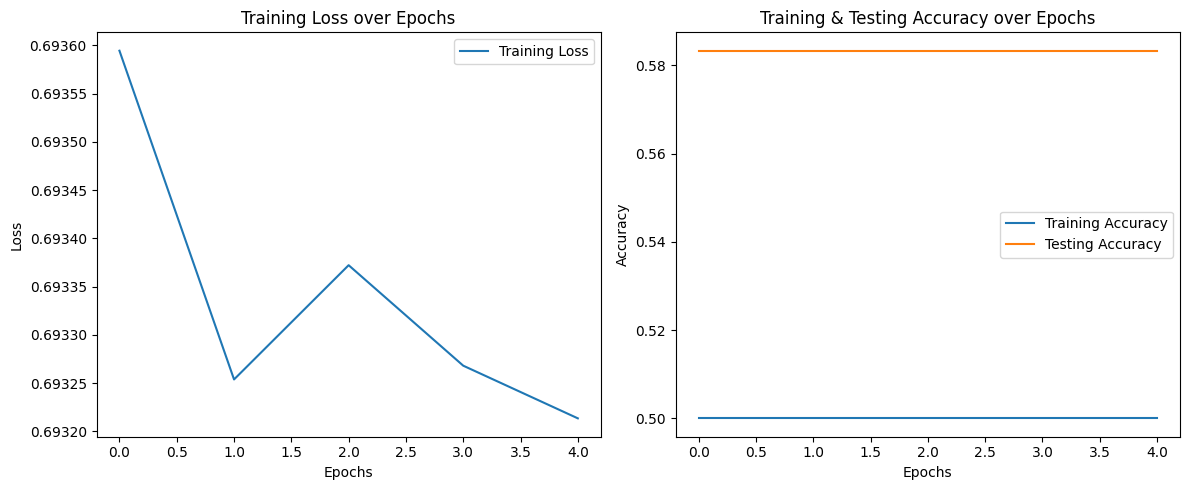

C:\Users\persu\AppData\Local\Temp\ipykernel_18592\2811698128.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if true_label != int(pred):


Accuracy on 40 test images: 0.5000
Indices of incorrectly labeled images: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


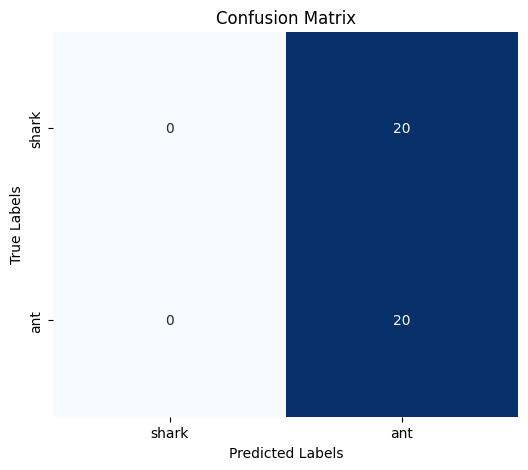

In [18]:
model = VGG5Blocks()

train_losses, train_accuracies, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, num_epochs= 5, batch_size=16, learning_rate=1e-5,model_name = "VGG5Blocks"
)

writer_images = SummaryWriter("runs/VGG5Blocks_Images")
plot_metrics(train_losses, train_accuracies, test_accuracies)
true_labels, predicted_labels ,incorrect_indices_vgg1 = plot_test_predictions_grid(
    model, test_loader, num_images=40, grid_size=(5, 8),writer = writer_images, device='cuda' if torch.cuda.is_available() else 'cpu'
)
plot_confusion_matrix(true_labels, predicted_labels, classes=["shark","ant"])
writer_images.close()

### Model performences:

| Model                                   | Training Time (seconds) | Training Loss | Training Accuracy (%) | Testing Accuracy (%) | Number of Parameters    |
|-----------------------------------------|-------------------------|---------------|------------------------|-----------------------|--------------------------|
| VGG (1 block)                           | 315.53                  | 0.0032        | 100.00                | 97.50                | 51,381,377              |
| VGG (2 block)                           | 356.91                  | 0.0426        | 98.75                 | 97.92                | 25,709,761              |
| VGG (3 block) with augmentation         | 604.69                  | 0.2238        | 93.75                 | 97.92                | 12,938,561              |
| VGG16 with all tuned layers             | 1353.69                 | 0.0216        | 99.38                 | 100.00               | 134,264,641             |
| VGG16 with tuned fully connected layers | 938.90                  | 0.0519        | 100.00                | 100.00               | 119,549,953 (Trainable) |
| Custom VGG16 like model                 | 1450.21                 | 0.6932        | 50.00                 | 58.33                | 134,264,641             |
